In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import IPython
import IPython.display
import pandas as pd
import numpy as np
import math
import scipy
import tempfile
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Make numpcy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.keras.utils import to_categorical #type: ignore
import matplotlib.pyplot as plt
import matplotlib as mat
#import colordict as cd
import seaborn as sns

from flowability_data_upload.Research import main
from flowability_data_upload.Research.main import trymodel, makemodel, modeltest

from statsmodels.graphics.regressionplots import abline_plot

from flowability_data_upload.Research.main import trymodel, makemodel, modeltest, Data

In [2]:
%%capture

def load_data():
    x = Data()
    x.importnewpowders()
    df_data = pd.DataFrame(x.data)
    df_flow = pd.DataFrame(x.flow)
    df_noflow = pd.DataFrame(x.noflow)

    return df_data, df_flow, df_noflow

df_data, df_flow, df_noflow = load_data()

In [3]:
pd.set_option('display.max_columns', None)
df_data.describe()

,Da,Dp,FWidth,FLength,ELength,EWidth,Volume,Area,Perimeter,CHull Area,CHull Perimeter,Sphericity,Compactness,Roundness,Ellipse Ratio,Circularity,Solidity,Concavity,Convexity,Extent,Transparency,Curvature,Surface Area,L/W Ratio,W/L Aspect Ratio,CHull Surface Area,Ellipticity,Flow,Flow Class
count,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,2.714330e+05,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000,271433.000000
mean,17.437426,19.584505,16.006094,20.989617,20.064784,15.574809,1.194712e+04,394.803286,61.526533,417.306852,58.768829,0.899650,0.831908,0.699995,0.794656,0.813635,0.944927,0.055073,0.969058,0.711475,0.369702,0.030291,1579.213144,1.348371,0.769345,1669.227407,1.321048,17.321739,0.557965
std,14.093120,16.539802,12.996290,17.264877,17.008509,12.737594,8.588047e+04,897.617276,51.961316,966.819265,47.467115,0.065308,0.089029,0.141272,0.148346,0.112077,0.046066,0.046066,0.034497,0.052250,0.059026,0.205644,3590.469105,0.303105,0.129415,3867.277062,0.359398,19.867035,0.496630
min,2.579000,3.620000,3.000000,3.840000,2.950000,2.067000,8.985000e+00,5.225000,11.373000,7.423000,11.046000,0.435000,0.291000,0.084000,0.098000,0.189000,0.700000,0.000000,0.548000,0.380000,0.000000,0.000000,20.900000,1.015000,0.124000,29.692000,1.000000,0.000000,0.000000
25%,8.120000,8.978000,7.462000,9.802000,9.166000,7.170000,2.803440e+02,51.787000,28.206000,54.896000,27.675000,0.867000,0.780000,0.608000,0.709000,0.752000,0.928000,0.024000,0.959000,0.686000,0.333000,0.000000,207.147000,1.150000,0.693000,219.583000,1.097000,0.000000,0.000000
50%,12.486000,13.765000,11.378000,14.978000,14.183000,11.128000,1.019258e+03,122.447000,43.244000,129.397000,42.106000,0.917000,0.850000,0.722000,0.832000,0.841000,0.958000,0.042000,0.982000,0.722000,0.383000,0.000000,489.787000,1.255000,0.797000,517.590000,1.201000,14.430000,1.000000
75%,22.466000,24.995000,20.670000,26.623000,25.589000,20.080000,5.936972e+03,396.400000,78.524000,419.254000,75.287000,0.949000,0.900000,0.810000,0.911000,0.900000,0.976000,0.072000,0.992000,0.748000,0.416000,0.000000,1585.602000,1.442000,0.869000,1677.015000,1.410000,34.310000,1.000000
max,395.289000,841.622000,375.143000,514.872000,473.644000,371.279000,3.234010e+07,122720.860000,2644.034000,145923.674000,1448.384000,0.993000,0.987000,0.974000,1.000000,0.986000,1.000000,0.300000,1.000000,0.894000,0.674000,6.250000,490883.440000,8.085000,0.985000,583694.696000,10.246000,64.303333,1.000000


# Training Classifiers

## Flow Class Prediction

In [4]:
#Flow Class Imbalance

neg, pos = np.bincount(df_data['Flow Class']) #type: ignore
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 271433
    Positive: 151450 (55.80% of total)



### Data Cleaning

In [48]:
cleaned_df = df_data.copy().reset_index(drop = True)

powder = cleaned_df.pop('Flow')
powder = cleaned_df.pop('Powder')

## Model Class

In [49]:
class Model:
    def __init__(self, name, num_classes = 2):
        self.name = name
        self.num_classes = num_classes

        self.EPOCHS = 100
        self.BATCH_SIZE = 2048
        

In [50]:
regular_model = Model(name = "Regular")
boxcox_model = Model(name="Boxcox Transform")

### Train Test Split

In [51]:
def split_transform_data(self, cleaned_df, target = 'Flow Class', use_boxcox = False):
    # Use a utility from sklearn to split and shuffle your dataset.
    train_df, self.test_df = train_test_split(cleaned_df, test_size=0.2)

    if use_boxcox:
        for col in train_df.columns[:-1]: #all except last (assuming target)
            fit_values, fit_lambda = scipy.stats.boxcox(train_df[col].values + 0.0001)
            train_df[col] = fit_values
            self.test_df[col] = scipy.stats.boxcox(self.test_df[col].values + 0.0001, fit_lambda)

    self.train_df, self.val_df = train_test_split(train_df, test_size=0.2)

    # Form np arrays of labels and features.
    self.train_labels = np.array(self.train_df.pop(target))
    self.bool_train_labels = self.train_labels != 0
    self.val_labels = np.array(self.val_df.pop(target))
    self.test_labels = np.array(self.test_df.pop(target))

    self.train_features = np.array(self.train_df)
    self.val_features = np.array(self.val_df)
    self.test_features = np.array(self.test_df)
      

Model.split_transform_data = split_transform_data

In [52]:
regular_model.split_transform_data(cleaned_df, use_boxcox=False)
boxcox_model.split_transform_data(cleaned_df, use_boxcox=True)

### Apply Standard Scaling

In [53]:
def apply_StandardScaler(self):
    scaler = StandardScaler()
    self.train_features = scaler.fit_transform(self.train_features)

    self.val_features = scaler.transform(self.val_features)
    self.test_features = scaler.transform(self.test_features)

    self.train_features = np.clip(self.train_features, -5, 5)
    self.val_features = np.clip(self.val_features, -5, 5)
    self.test_features = np.clip(self.test_features, -5, 5)


    print('Training labels shape:', self.train_labels.shape)
    print('Validation labels shape:', self.val_labels.shape)
    print('Test labels shape:', self.test_labels.shape)

    print('Training features shape:', self.train_features.shape)
    print('Validation features shape:', self.val_features.shape)
    print('Test features shape:', self.test_features.shape)

Model.apply_StandardScaler = apply_StandardScaler

In [54]:
regular_model.apply_StandardScaler()
boxcox_model.apply_StandardScaler()

Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)
Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 27)
Validation features shape: (43430, 27)
Test features shape: (54287, 27)


### Define Model and Metrics

In [55]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

Model.METRICS = METRICS

def make_model(self, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  self.model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(self.train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  self.model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=self.METRICS)

  return self.model

Model.make_model = make_model

def evaluate_model(self):
  results = self.model.evaluate(self.train_features, self.train_labels, batch_size = self.BATCH_SIZE, verbose=0)
  print("Loss: {:0.4f}".format(results[0]))

Model.evaluate_model = evaluate_model

def fit_model(self):

  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

  self.history = self.model.fit(
    self.train_features,
    self.train_labels,
    batch_size=self.BATCH_SIZE,
    epochs=self.EPOCHS,
    callbacks=[early_stopping],
    validation_data=(self.val_features, self.val_labels))

  return self.history

Model.fit_model = fit_model

def predict(self, input):
    # make predictions on the input data using the model
    scaler = StandardScaler()
    scaled_input = scaler.fit_transform(input)

    predictions = self.model.predict(scaled_input)
    
    return predictions

Model.predict = predict
  

### Visualization

In [100]:
def visualize(self):
    pos_df = pd.DataFrame(self.train_features[self.bool_train_labels], columns=self.train_df.columns)
    neg_df = pd.DataFrame(self.train_features[~self.bool_train_labels], columns=self.train_df.columns)

    f1,f2 = np.random.choice(self.train_df.columns, 2, replace=False)

    sns.jointplot(x=pos_df[f1], y=pos_df[f2],
                kind='hex', xlim=(-5,5), ylim=(-5,5))
    plt.suptitle("Positive distribution")

    sns.jointplot(x=neg_df[f1], y=neg_df[f2],
                kind='hex', xlim=(-5,5), ylim=(-5,5))
    _ = plt.suptitle("Negative distribution")

Model.visualize = visualize

def plot_metrics(self):

  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(self.history.epoch, self.history.history[metric], color=colors[0], label='Train')
    plt.plot(self.history.epoch, self.history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

Model.plot_metrics = plot_metrics

def plot_cm(self, p=0.5):
  predictions = self.model.predict(self.test_features)
  cm = confusion_matrix(self.test_labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('No Flow Detected (True Negatives): ', cm[0][0])
  print('Flow Incorrectly Detected (False Positives): ', cm[0][1])
  print('No Flow Incorrectly Detected (False Negatives): ', cm[1][0])
  print('Flow Detected (True Positives): ', cm[1][1])
  print('Total Flow Detected: ', np.sum(cm[1]))

Model.plot_cm = plot_cm

### Plot Model Training History

#### Regular

In [56]:
model = regular_model.make_model()
history = regular_model.fit_model()
IPython.display.clear_output()
regular_model.evaluate_model()

Loss: 0.5600


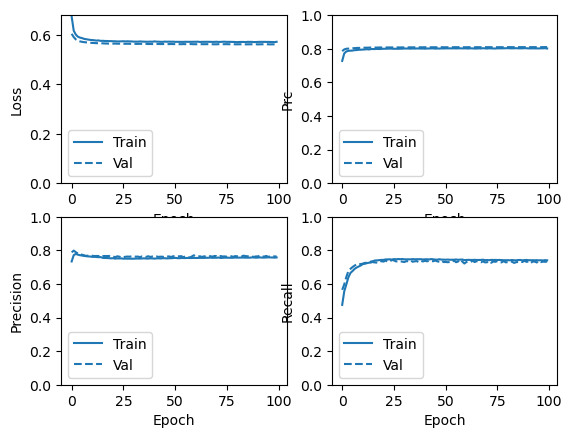

In [15]:
regular_model.plot_metrics()

1697/1697 [==============================] - 1s 444us/step
No Flow Detected (True Negatives):  17036
Flow Incorrectly Detected (False Positives):  6797
No Flow Incorrectly Detected (False Negatives):  8020
Flow Detected (True Positives):  22434
Total Flow Detected:  30454


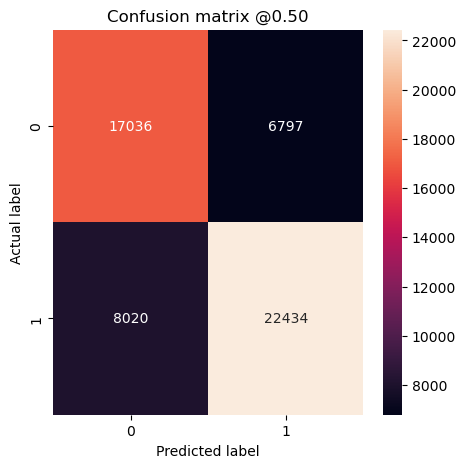

In [16]:
regular_model.plot_cm()

#### Boxcox Transform

In [17]:
model = boxcox_model.make_model()
history = boxcox_model.fit_model()
IPython.display.clear_output()
boxcox_model.evaluate_model()

Loss: 0.5631


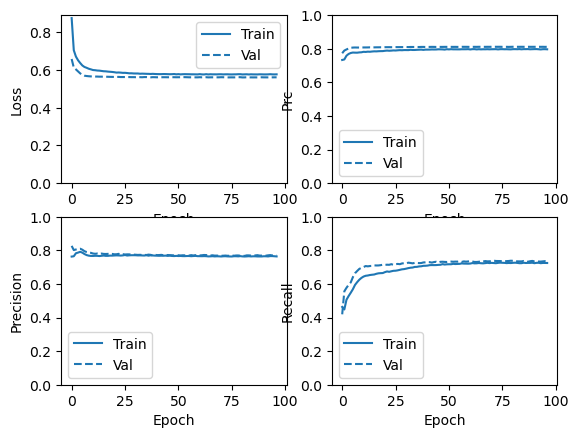

In [18]:
boxcox_model.plot_metrics()

1697/1697 [==============================] - 1s 438us/step
No Flow Detected (True Negatives):  17294
Flow Incorrectly Detected (False Positives):  6742
No Flow Incorrectly Detected (False Negatives):  8227
Flow Detected (True Positives):  22024
Total Flow Detected:  30251


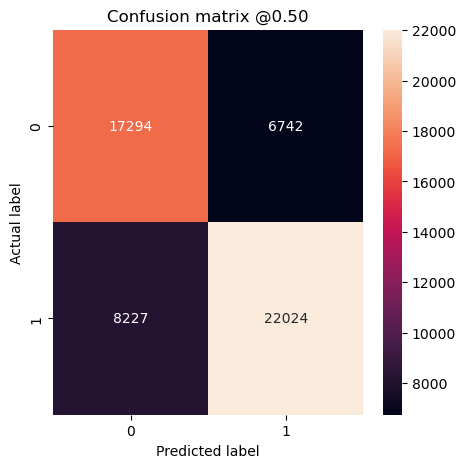

In [19]:
boxcox_model.plot_cm()

## Powder Class Prediction

In [20]:
#Powder Class Imbalance
encoded_df = df_data.copy().reset_index(drop = True)

encoded_df.pop('Flow Class')
encoded_df.pop('Flow')

le = LabelEncoder()
encoded_df['Powder Class'] = le.fit_transform(encoded_df['Powder'])#type: ignore
num_classes = len(le.classes_)
counts = np.bincount(encoded_df['Powder Class']) 
total = sum(counts)

for label,count in zip(le.classes_,counts):
    print(f"Label {label} : {count} ({count/total * 100:.2f}% of total)")
    break

encoded_df.pop('Powder')
class_labels = encoded_df.pop('Powder Class')


Label AEE_WP-301_1-5_AA_3-7.txt : 8659 (3.19% of total)


In [21]:
powder_class_model = Model(name="Powder Class Models", num_classes = num_classes)

### Use Flow Class Model predictions

In [22]:
predictions = regular_model.predict(encoded_df)
encoded_df['Predicted Flow Class'] = predictions
encoded_df['Powder Class'] = class_labels

8483/8483 [==============================] - 3s 402us/step


In [23]:
powder_class_model.split_transform_data(encoded_df, target = "Powder Class")

In [24]:
powder_class_model.apply_StandardScaler()

Training labels shape: (173716,)
Validation labels shape: (43430,)
Test labels shape: (54287,)
Training features shape: (173716, 28)
Validation features shape: (43430, 28)
Test features shape: (54287, 28)


### Define Multiclass Model and Metrics

In [86]:
MC_METRICS = [
    #keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.TopKCategoricalAccuracy(name='top_k_accuracy'),
    keras.metrics.CategoricalCrossentropy(name='crossentropy'),
    #keras.metrics.CategoricalHinge(name='hinge'),
    keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
    #keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy'),
]

Model.MC_METRICS = MC_METRICS

def make_multiclass_model(self):
  self.train_labels_onehot = to_categorical(self.train_labels)
  self.val_labels_onehot = to_categorical(self.val_labels)
  self.test_labels_onehot = to_categorical(self.test_labels)

  # define the model
  model = keras.Sequential()
  model.add(keras.layers.Dense(128, input_dim=self.train_features.shape[1], activation='relu'))
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dense(self.num_classes, activation='softmax'))

  # compile the model
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=self.MC_METRICS)

  # store the model in the class
  self.multiclass_model = model

  # return the model
  return model

Model.make_multiclass_model = make_multiclass_model

def evaluate_multiclass_model(self):
  results = self.multiclass_model.evaluate(self.train_features, self.train_labels_onehot, batch_size = self.BATCH_SIZE, verbose=0)
  print("Loss: {:0.4f}".format(results[0]))
  return results

Model.evaluate_multiclass_model = evaluate_multiclass_model

def fit_multiclass_model(self):

  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

  self.history = self.multiclass_model.fit(
    self.train_features,
    self.train_labels_onehot,
    batch_size=self.BATCH_SIZE,
    epochs=self.EPOCHS,
    callbacks=[early_stopping],
    validation_data=(self.val_features, self.val_labels_onehot))

  return self.history

Model.fit_multiclass_model = fit_multiclass_model

### Fit Multiclass Model

In [26]:
model = powder_class_model.make_multiclass_model()
history = powder_class_model.fit_multiclass_model()
IPython.display.clear_output()
powder_class_model.evaluate_multiclass_model()

Loss: 2.0322


### Evaluate on Test Set

In [74]:
def multiclass_predict(self):

    # make predictions on the input data using the model
    

    pred = self.multiclass_model.predict(self.test_features)
    
    self.pred = pred

    self.class_predictions = tf.math.argmax(pred, axis = 1)

    return pred

Model.multiclass_predict = multiclass_predict

In [28]:
predictions = powder_class_model.multiclass_predict()

1697/1697 [==============================] - 1s 449us/step


In [69]:
def plot_multiclass_cm(self):
    cm = confusion_matrix(self.test_labels, self.class_predictions)
    cm_df = pd.DataFrame(cm)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=False)
    plt.title("Confusion Matrix")
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
Model.plot_multiclass_cm = plot_multiclass_cm

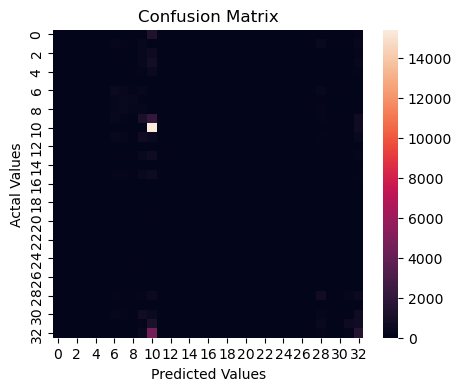

In [30]:
powder_class_model.plot_multiclass_cm()

## Multiclass with Resampling

In [88]:
def resample(df_data, target = "Powder", n = 10000):
    grouped_df = df_data.groupby('Powder')
    # create a new dataframe to hold the resampled rows
    resampled_df = pd.DataFrame()

    # for each group in the grouped dataframe
    for name, group in grouped_df:
        # if the number of rows in the group is greater than n
        if len(group) > n:
            # undersample the group without replacement
            resampled_group = group.sample(n=n, replace=False)
        else:
            # oversample the group with replacement
            resampled_group = group.sample(n=n, replace=True)
        # append the resampled group to the resampled dataframe
        resampled_df = pd.concat([resampled_df, resampled_group], axis = 0)

    # print the resampled dataframe
    resampled_df = resampled_df.reset_index(drop = True)

    return resampled_df

In [89]:
resampled_df = resample(df_data)


le = LabelEncoder()
resampled_df['Powder Class'] = le.fit_transform(resampled_df['Powder'])#type: ignore
num_classes = len(le.classes_)
counts = np.bincount(resampled_df['Powder Class']) 
total = sum(counts)

for label,count in zip(le.classes_,counts):
    print(f"Label {label} : {count} ({count/total * 100:.2f}% of total)")
    break

resampled_df.pop('Powder')
resampled_df.pop('Flow Class')
resampled_df.pop('Flow')

class_labels = resampled_df.pop('Powder Class')

Label AEE_WP-301_1-5_AA_3-7.txt : 10000 (3.03% of total)


In [79]:
pc_resample_model = Model(name="Powder Class Resample Model", num_classes = num_classes)

In [80]:
predictions = regular_model.predict(resampled_df)
resampled_df['Predicted Flow Class'] = predictions
resampled_df['Powder Class'] = class_labels

10313/10313 [==============================] - 4s 397us/step


In [81]:
pc_resample_model.split_transform_data(resampled_df, target = "Powder Class")

In [82]:
pc_resample_model.apply_StandardScaler()

Training labels shape: (211200,)
Validation labels shape: (52800,)
Test labels shape: (66000,)
Training features shape: (211200, 28)
Validation features shape: (52800, 28)
Test features shape: (66000, 28)


In [83]:
model = pc_resample_model.make_multiclass_model()
history = pc_resample_model.fit_multiclass_model()
IPython.display.clear_output()
pc_resample_model.evaluate_multiclass_model()

Loss: 2.3018


In [87]:
pc_resample_model.evaluate_multiclass_model()

Loss: 2.3018


[2.3018014430999756,
 0.663375973701477,
 2.3018014430999756,
 0.27999526262283325]

In [84]:
predictions = pc_resample_model.multiclass_predict()

2063/2063 [==============================] - 1s 447us/step


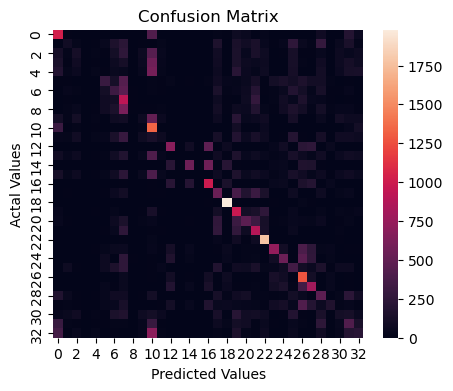

In [85]:
pc_resample_model.plot_multiclass_cm()

## Flow Class Resample

In [93]:
powder_balanced_df = resample(df_data)

powder_balanced_df.pop("Powder")

neg, pos = np.bincount(powder_balanced_df['Flow Class']) #type: ignore
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 330000
    Positive: 240000 (72.73% of total)



In [97]:
balanced_model = Model(name = "Balanced Model", num_classes= 2)

balanced_model.split_transform_data(powder_balanced_df)

balanced_model.apply_StandardScaler()

Training labels shape: (211200,)
Validation labels shape: (52800,)
Test labels shape: (66000,)
Training features shape: (211200, 28)
Validation features shape: (52800, 28)
Test features shape: (66000, 28)


In [99]:
model = balanced_model.make_model()
history = balanced_model.fit_model()
IPython.display.clear_output()
balanced_model.evaluate_model()

Loss: 0.0016


2063/2063 [==============================] - 1s 395us/step
No Flow Detected (True Negatives):  17975
Flow Incorrectly Detected (False Positives):  4
No Flow Incorrectly Detected (False Negatives):  0
Flow Detected (True Positives):  48021
Total Flow Detected:  48021


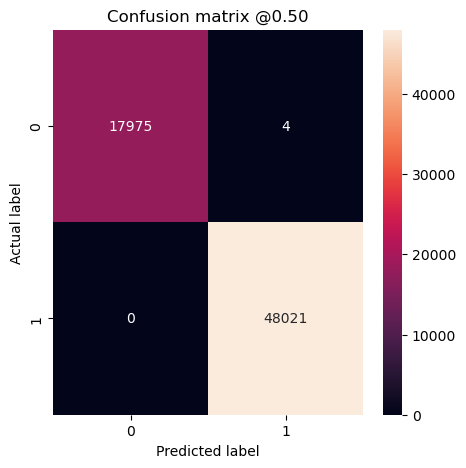

In [101]:
balanced_model.plot_cm()

# Training Encoders